In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import seaborn as sns
import math

import datetime


import random
from collections import deque

plt.style.use('ggplot')

import sys 
sys.path.append('..')


In [18]:
df = pd.read_csv("../data/ChargePoint Data CY20Q4_fixed_dates.csv", index_col=0)
df = df[df['End Date'] >= '2017-01-01']
df_webster = df[df.Cluster == 'WEBSTER']

pred_webster = pd.read_csv('../predictions/best_sweep_tgcn_dynamic_2/predictions_TGCN_WEBSTER_trim-shape-30_2.csv', index_col=0)

pred_webster = pred_webster.iloc[:2831]
pred_webster = pred_webster.reset_index(drop=False)

In [19]:

def add_time_columns(df_in, date_name = 'Start Date'):
    df_out = df_in.copy()
    df_out['Start Date Rounded'] = df_out[date_name].apply(lambda x: pd.to_datetime(x).round('30min'))
    df_out['DayOfWeek'] = df_out[date_name].apply(lambda x: pd.to_datetime(x).dayofweek)

    df_out['Hour'] = df_out['Start Date Rounded'].apply(lambda x: pd.to_datetime(x).hour)
    df_out['Minute'] = df_out['Start Date Rounded'].apply(lambda x: pd.to_datetime(x).minute)
    df_out['HourMinute'] = df_out['Hour'].astype(str) + ':' + df_out['Minute'].astype(str)

    df_out = df_out.drop(columns = 'Start Date Rounded')
    #df_out['HourMinute'] = pd.to_datetime(df_out['HourMinute'].dt.round('30min'))

    return df_out


df_webster = add_time_columns(df_webster)
pred_webster = add_time_columns(pred_webster, date_name='Date')

In [21]:
## Extract arrival rates from predictions
pred_webster['ArrivalRate'] = pred_webster['WEBSTER_1_pred'].diff(periods=1)
pred_webster = pred_webster.fillna(0)
pred_webster.loc[(pred_webster['ArrivalRate'] < 0), 'ArrivalRate'] = 0 

## Convert service time to hour 
df_webster['Total Duration (hour)'] = df_webster['Total Duration (min)'] / 60

<AxesSubplot:xlabel='Hour', ylabel='Total Duration (min)'>

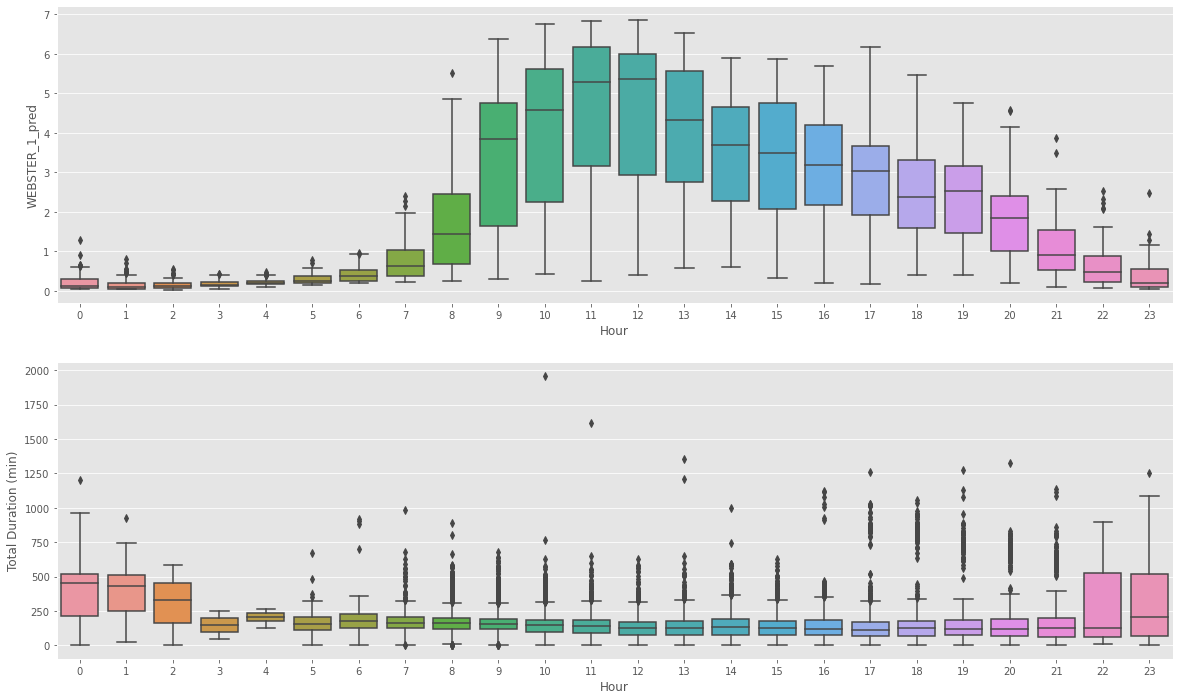

In [28]:
fig, axes = plt.subplots(2, figsize=(20,12))
sns.boxplot(data=pred_webster, x="Hour", y="WEBSTER_1_pred", ax = axes[0])
sns.boxplot(data=df_webster, x="Hour", y="Total Duration (min)", ax = axes[1])


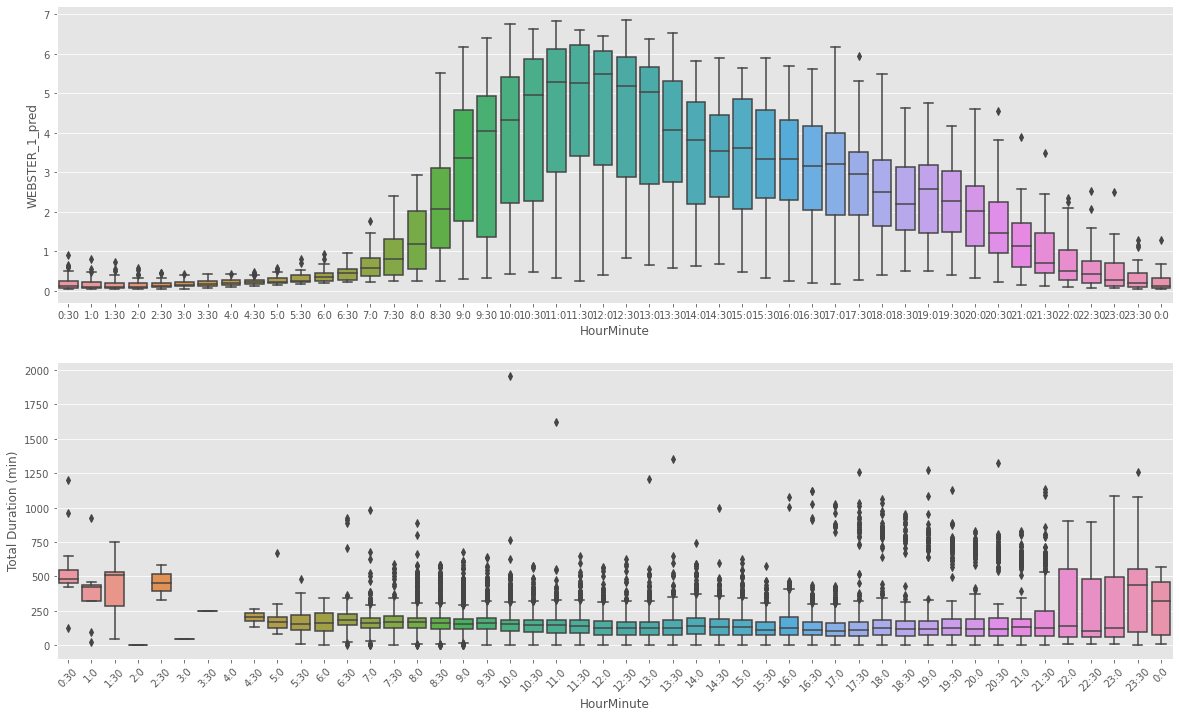

In [40]:
fig, axes = plt.subplots(2, figsize=(20,12))
sns.boxplot(data=pred_webster, x="HourMinute", y="WEBSTER_1_pred", ax = axes[0])
sns.boxplot(data=df_webster, x="HourMinute", y="Total Duration (min)", ax = axes[1], order=pred_webster['HourMinute'].unique())
plt.xticks(rotation=45)
plt.show()

In [41]:
import ipywidgets as widgets
import pandas as pd
import matplotlib.pyplot as plt

cluster_name = 'WEBSTER'
day_of_week_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']



def plot_histogram_hour(hour, day_of_week):
    fig, axs = plt.subplots(figsize=(12, 8))
    time_specific_df = pred_webster[(pred_webster['DayOfWeek'] == day_of_week) & (pred_webster['Hour'] == hour)]
    bins = range(0, int(time_specific_df[cluster_name + '_1_pred' ].max()) + 2)
    axs.hist(time_specific_df[cluster_name + '_1_pred'], density=True, edgecolor='black', linewidth=1.2, bins=list(bins))
    # make x axis integer
    axs.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    axs.set_title(f'Predidctions on {day_of_week_list[day_of_week]} {hour}')
    plt.show()

hour_intervals = list(range(24))# [f'{hour:1d}' for hour in range(24)]
hour_widget = widgets.SelectionSlider(
    options=hour_intervals,
    value=0,
    description='Hour:',
    disabled=False,
    continuous_update=True,
)

day_of_week_intervals = list(range(7))
day_of_week_widget = widgets.SelectionSlider(
    options=day_of_week_intervals,
    value=0,
    description='Day of week:',
    disabled=False,
    continuous_update=True,
)

widgets.interact(plot_histogram_hour, hour=hour_widget, day_of_week=day_of_week_widget)

interactive(children=(SelectionSlider(description='Hour:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, …

<function __main__.plot_histogram_hour(hour, day_of_week)>

In [53]:
webster_hourly_pluginTime = df_webster.groupby('Hour').mean()
webster_hourly_pluginTime = webster_hourly_pluginTime.reset_index(drop=False)[['Hour', 'Total Duration (min)', 'Total Duration (hour)']]
webster_hourly_pluginTime = webster_hourly_pluginTime.rename(columns={'Total Duration (min)': 'AverageDuration (min)', 'Total Duration (hour)': 'Average Duration (hour)'})

webster_hourly_prediction = pred_webster.groupby('Hour').mean()
webster_hourly_prediction = webster_hourly_prediction.reset_index(drop=False)[['Hour', 'WEBSTER_1_pred', 'ArrivalRate']]
webster_hourly_prediction = webster_hourly_prediction.rename(columns={'WEBSTER_1_pred': 'AveragePrediction', 'ArrivalRate': 'AverageArrivalRate'})


In [54]:
webster_half_hourly_pluginTime = df_webster.groupby('HourMinute').mean()
webster_half_hourly_pluginTime = webster_half_hourly_pluginTime.reset_index(drop=False)[['HourMinute', 'Total Duration (min)', 'Total Duration (hour)']]
webster_half_hourly_pluginTime = webster_half_hourly_pluginTime.rename(columns={'Total Duration (min)': 'AverageDuration (min)', 'Total Duration (hour)': 'Average Duration (hour)'})

webster_half_hourly_prediction = pred_webster.groupby('HourMinute').mean()
webster_half_hourly_prediction = webster_half_hourly_prediction.reset_index(drop=False)[['HourMinute', 'WEBSTER_1_pred', 'ArrivalRate']]
webster_half_hourly_prediction = webster_half_hourly_prediction.rename(columns={'WEBSTER_1_pred': 'AveragePrediction', 'ArrivalRate': 'AverageArrivalRate'})

#### Apply to queue

#### Queue estimating length with our predictions and waiting times as mean service time

In [ ]:
## Try to run below

In [ ]:
def queue_length_wait_times(df_prediction, df_observed, cluster = 'WEBSTER', time_resolution = 'HourMinute', no_of_plugs = 4):

    ## Create arrival rate column
    df_prediction['ArrivalRate'] = df_prediction['WEBSTER_1_pred'].diff(periods=1)
    df_prediction = df_prediction.fillna(0)
    df_prediction.loc[(df_prediction['ArrivalRate'] < 0), 'ArrivalRate'] = 0 

    ## Aggerate waiting times 
    df_pluginTime = df_observed.groupby(time_resolution).mean()
    df_pluginTime = df_pluginTime.reset_index(drop=False)[[time_resolution, 'Total Duration (min)', 'Total Duration (hour)']]
    df_pluginTime = df_pluginTime.rename(columns={'Total Duration (min)': 'AverageDuration (min)', 'Total Duration (hour)': 'Average Duration (hour)'})

    
    ## Add queue length 
    df_prediction['QueueLength'] = np.zeros(len(df_prediction))
    df_prediction.loc[(df_prediction[cluster + '_1_pred'] >= 4), 'QueueLength'] = (df_prediction[cluster + '_1_pred'] - no_of_plugs)


    ## Merge predictions and waiting times

    df_prediction_Wtime = df_prediction_Wtime.merge(
        df_pluginTime,
        how="left",
        on = time_resolution)

    df_prediction_Wtime['WaitingTime'] = np.zeros(len(df_prediction_Wtime))
    df_prediction_Wtime.loc[(df_prediction_Wtime['QueueLength']!= 0), 'WaitingTime'] = (df_prediction_Wtime['QueueLength']*df_prediction_Wtime['AverageDuration (min)'] )

    return df_prediction_Wtime


In [57]:
webster_hourly_pluginTime['AverageDuration (hour)'] = webster_hourly_pluginTime['AverageDuration (min)'] / 60
webster_half_hourly_pluginTime['AverageDuration (hour)'] = webster_half_hourly_pluginTime['AverageDuration (min)'] / 60

In [58]:
## Add queue length
pred_webster['QueueLength'] = np.zeros(len(pred_webster))
pred_webster.loc[(pred_webster['WEBSTER_1_pred'] >= 4), 'QueueLength'] = (pred_webster['WEBSTER_1_pred'] - 4)

## For hourly aggregated
webster_hourly_prediction['QueueLength'] = np.zeros(len(webster_hourly_prediction))
webster_hourly_prediction.loc[(webster_hourly_prediction['AveragePrediction'] >= 4), 'QueueLength'] = (webster_hourly_prediction['AveragePrediction'] - 4)


In [59]:
## Add queue length
pred_webster['QueueLength'] = np.zeros(len(pred_webster))
pred_webster.loc[(pred_webster['WEBSTER_1_pred'] >= 4), 'QueueLength'] = (pred_webster['WEBSTER_1_pred'] - 4)

## For hourly aggregated
webster_hourly_prediction['QueueLength'] = np.zeros(len(webster_hourly_prediction))
webster_hourly_prediction.loc[(webster_hourly_prediction['AveragePrediction'] >= 4), 'QueueLength'] = (webster_hourly_prediction['AveragePrediction'] - 4)

In [60]:
merged_webster = pred_webster.merge(
    webster_half_hourly_pluginTime,
    how="left",
    on = 'HourMinute')

merged_webster['WaitingTime'] = np.zeros(len(merged_webster))
merged_webster.loc[(merged_webster['QueueLength']!= 0), 'WaitingTime'] = (merged_webster['QueueLength']*merged_webster['AverageDuration (min)'] )


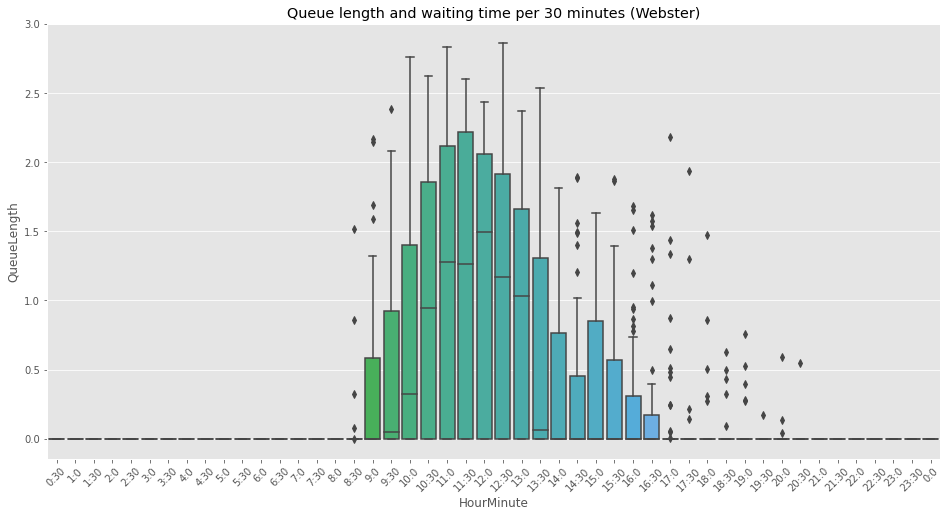

In [97]:
fig, axes = plt.subplots(1, figsize=(16,8), sharex=True)
axes.set_title('Queue length per 30 minutes (Webster)')
sns.boxplot(data=merged_webster, x="HourMinute", y="QueueLength", ax = axes)
plt.xticks(rotation=45)
#ax2 = plt.twinx()
#sns.boxplot(data=merged_webster, x = 'HourMinute', y = 'WaitingTime', ax = ax2)
plt.show()


##### Below is an attempt to use queuing theory (poisson arrival, exponential service times)

In [ ]:
def mmc_queue_hour(lambd, mu, c, time_horizon, seed=None):
    ## Function to simulate an hour 

    random.seed(seed)  # Set seed for reproducibility

    ## use predictions and observed service times to sample from

    ## sample arrival times

    # interarrival_times = np.random.poisson(lambd, num_customers)
    arrivals = np.random.poisson(lambd, time_horizon)

    ## sample service times
    service_times = np.random.exponential(1/mu, time_horizon)

    #print(service_times)
    #arrival_times = np.cumsum(interarrival_times)
    departure_times = np.zeros(time_horizon)

    queue_length = []

    queue = []  # Create an empty queue
    completed_customers = []
    rejected_customers = 0

    for i in range(time_horizon):
        queue_length.append(len(queue))
        
        for k in range(len(queue)):
            if (queue[k] < i):
                queue.pop()
        
        # If a customer arrives at time i,
        if (arrivals[i] > 0):
            if len(queue) < c:
                departure_time = i + service_times[i]
                queue.append(departure_time)

                # keep lowest depature time first
                queue.sort(reverse=True)

            else:
                rejected_customers += 1
        
            completed_customers.append((i, departure_time))

    return completed_customers, queue_length, rejected_customers

        

In [85]:
def mmc_queue_day(df_sessions, c, time_horizon, seed=None, hour = False, time_resolution = 'HourMinute'):
    random.seed(seed)  # Set seed for reproducibility

    ## choose arrival and service rates
    arrivals = []
    service_times = []
    for i in merged_webster[time_resolution].unique():
        lambd = np.random.choice(df_sessions[df_sessions[time_resolution] == i]['ArrivalRate'])
        mu = np.random.choice(1/df_sessions[df_sessions[time_resolution] == i]['AverageDuration (min)'])
        
        arrivals.append(np.random.poisson(lambd, 1))
        service_times.append(np.random.exponential(1/mu, 1))
        
        #if (hour == True):
        #    arrivals.append(np.random.poisson(lambd, 1))
        #    service_times.append(np.random.exponential(1/mu, 1))
            
        #elif(hour == False ):
        #    arrivals.append(np.random.poisson(lambd, 60))
        #    service_times.append(np.random.exponential(1/mu, 60))



    arrivals = [item for sublist in arrivals for item in sublist]
    service_times = [item for sublist in service_times for item in sublist]

    service_times = [0 if math.isnan(x) else x for x in service_times]
    
    #print(arrivals)
    #print(service_times)

    departure_times = np.zeros(time_horizon)

    queue_length = []

    queue = []  # Create an empty queue
    completed_customers = []
    rejected_customers = 0

    for i in range(time_horizon):
        queue_length.append(len(queue))
        
        k = len(queue) - 1
        while k >= 0:
            if queue[k] < i:
                queue.pop(k)
            k -= 1
            
        #for k in range(len(queue)):
        #    if (queue[k] < i):
        #        queue.pop()
        
        # If a customer arrives at time i,
        if (arrivals[i] > 0):
            if len(queue) < c:
                departure_time = i + service_times[i]
                queue.append(departure_time)

                # keep lowest depature time first
                queue.sort(reverse=True)

            else:
                rejected_customers += 1
        
            completed_customers.append((i, departure_time))

    return completed_customers, queue_length, rejected_customers

Rejected  0 customers during a simulated day


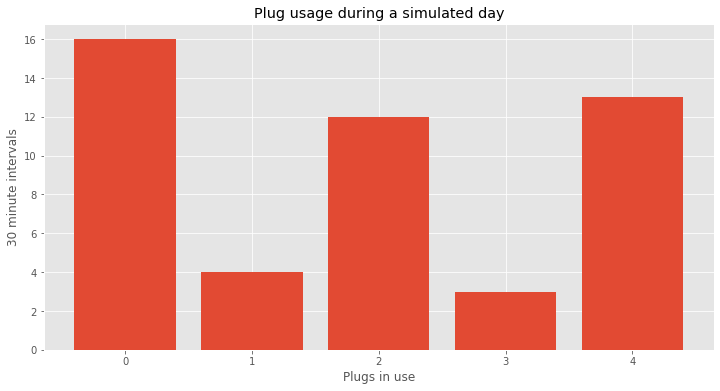

In [86]:
# Example usage
#hour_index = 20
#lambd =  webster_hourly_prediction.iloc[hour_index]['ArrivalRate']  # arrival time np.random.choice(webster_hourly_pluginTime, 1)[0]
#mu =  1 / (webster_hourly_pluginTime.iloc[hour_index]['Total Duration (min)']) # service time  np.random.choice(webster_hourly_pluginTime, 1)[0]  

c = 4  # Number of servers
sim_time = 48 # Number of minutes to simulate

completed_customers, queue_length, rejects = mmc_queue_day(merged_webster, c, sim_time, hour=True)


# print('Rejected % i customers due to insuffient plugs from %ih and %i minutes ahead' % (rejects, hour_index, sim_time) )
print('Rejected % i customers during a simulated day' % (rejects) )


bins = np.arange(min(queue_length), max(queue_length) + 2) - 0.5

fig, ax = plt.subplots(figsize=(12,6))
ax.hist(queue_length, bins = bins, align='mid', rwidth=0.8)
ax.set_title('Plug usage during a simulated day')
ax.set_xlabel('Plugs in use')
ax.set_ylabel('30 minute intervals')
ax.set_xticks(range(int(min(queue_length)), int(max(queue_length) + 1)))
plt.show()

In [95]:

no_simulations = 1000
c = 6  # Number of servers
sim_time = 48 # Number of minutes to simulate
reject_list = []

for i in range(no_simulations):
    completed_customers, queue_length, rejects = mmc_queue_day(merged_webster, c, sim_time, hour=True)
    reject_list.append(rejects)


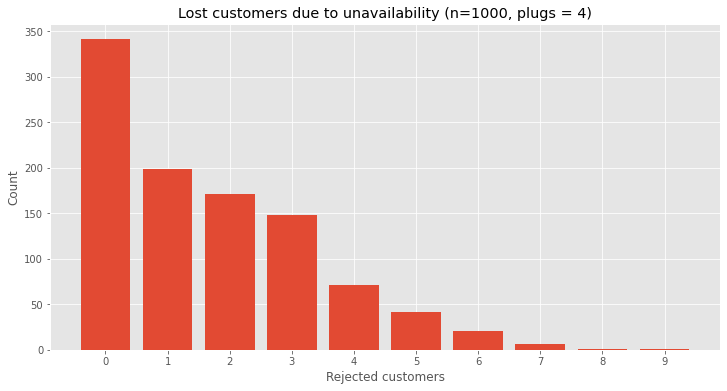

In [94]:
reject_list_c4 = reject_list

bins = np.arange(min(reject_list), max(reject_list) + 2) - 0.5

fig, ax = plt.subplots(figsize=(12,6))
ax.hist(reject_list, bins = bins, align='mid', rwidth=0.8)
ax.set_title('Lost customers due to unavailability (n=1000, plugs = 4)')
ax.set_xlabel('Rejected customers')
ax.set_ylabel('Count')
ax.set_xticks(range(int(min(reject_list)), int(max(reject_list) + 1)))
plt.show()

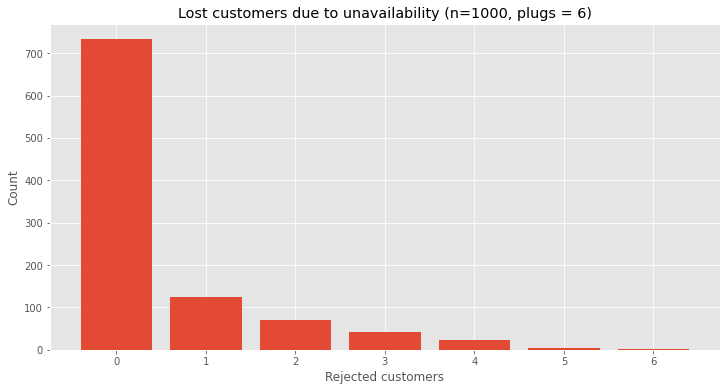

In [96]:
bins = np.arange(min(reject_list), max(reject_list) + 2) - 0.5

fig, ax = plt.subplots(figsize=(12,6))
ax.hist(reject_list, bins = bins, align='mid', rwidth=0.8)
ax.set_title('Lost customers due to unavailability (n=1000, plugs = 6)')
ax.set_xlabel('Rejected customers')
ax.set_ylabel('Count')
ax.set_xticks(range(int(min(reject_list)), int(max(reject_list) + 1)))
plt.show()